In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import shap
import os


from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, OneHotEncoder, FunctionTransformer, PolynomialFeatures, MaxAbsScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,StackingRegressor, StackingClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, SelectFromModel
from xgboost import XGBClassifier,XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Input,Conv1D


import warnings
warnings.filterwarnings('ignore')



from google.colab import drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

In [39]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Federated Learning/weather_data.csv')
df.head()

,Observation station,Year,Month,Day,Time [Local time],Average temperature [°C],Maximum temperature [°C],Minimum temperature [°C],Average relative humidity [%],Wind speed [m/s],Maximum wind speed [m/s],Average wind direction [°],Maximum gust speed [m/s],Precipitation [mm],Average air pressure [hPa]
0,Kustavi Isokari,2023,4,1,00:00,-0.6,-0.4,-0.8,82,6,6.4,15,7.6,0.0,1007.5
1,Kustavi Isokari,2023,4,1,01:00,-0.7,-0.4,-1.0,84,5.3,5.7,30,6.4,0.0,1007.8
2,Kustavi Isokari,2023,4,1,02:00,-1.0,-0.9,-1.1,80,5.6,6.2,27,6.9,0.0,1007.9
3,Kustavi Isokari,2023,4,1,03:00,-1.2,-1.0,-1.5,78,5.4,6,23,6.7,0.0,1008.2
4,Kustavi Isokari,2023,4,1,04:00,-1.0,-0.8,-1.3,77,6.3,7.4,17,8.5,0.0,1008.4


In [40]:
df.shape

(720, 15)

In [41]:
df['Time [Local time]'].unique()

array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'], dtype=object)

In [42]:
data=df.copy()

In [43]:
data.dtypes

,0
Observation station,object
Year,int64
Month,int64
Day,int64
Time [Local time],object
Average temperature [°C],float64
Maximum temperature [°C],float64
Minimum temperature [°C],float64
Average relative humidity [%],int64
Wind speed [m/s],object


In [35]:
d = {'date': pd.to_datetime(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04','2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04','2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04']),
        'value': [10, 12, 15, 13,10, 12, 15, 13,10, 12, 15, 13]}
d= pd.DataFrame(d)

for lag in range(1, 6):
    d[f"{'value'} lag_{lag}"] = d['value'].shift(lag)

d['y'] = d['value'].shift(-5)
d.dropna(inplace=True)
d.head(10)

,date,value,value lag_1,value lag_2,value lag_3,value lag_4,value lag_5,y
5,2023-01-02,12,10.0,13.0,15.0,12.0,10.0,15.0
6,2023-01-03,15,12.0,10.0,13.0,15.0,12.0,13.0


In [44]:
numeric_cols=['Wind speed [m/s]','Maximum wind speed [m/s]','Average wind direction [°]','Maximum gust speed [m/s]']
data[numeric_cols]=data[numeric_cols].apply(pd.to_numeric,errors='coerce')

data.fillna(0,inplace=True)

data['time stamp']=pd.to_datetime(
    data['Year'].astype(str)+' '+
    data['Month'].astype(str)+' '+
    data['Day'].astype(str)+' '+
    data['Time [Local time]'].astype(str)
)

excluded_cols=['Observation station','time stamp','Year','Month','Day','Time [Local time]']
col_lag=[col for col in data.columns if col not in excluded_cols]

for lag in range(1,6):
    for col in col_lag:
        data[f"{col} lag_{lag}"]=data[col].shift(lag)

data['y']=data['Average temperature [°C]'].shift(-5)
data.dropna(inplace=True)

data.head(10)

,Observation station,Year,Month,Day,Time [Local time],Average temperature [°C],Maximum temperature [°C],Minimum temperature [°C],Average relative humidity [%],Wind speed [m/s],...,Maximum temperature [°C] lag_5,Minimum temperature [°C] lag_5,Average relative humidity [%] lag_5,Wind speed [m/s] lag_5,Maximum wind speed [m/s] lag_5,Average wind direction [°] lag_5,Maximum gust speed [m/s] lag_5,Precipitation [mm] lag_5,Average air pressure [hPa] lag_5,y
5,Kustavi Isokari,2023,4,1,05:00,-1.0,-0.9,-1.2,75,7.0,...,-0.4,-0.8,82.0,6.0,6.4,15.0,7.6,0.0,1007.5,-0.9
6,Kustavi Isokari,2023,4,1,06:00,-1.4,-1.1,-1.7,72,5.8,...,-0.4,-1.0,84.0,5.3,5.7,30.0,6.4,0.0,1007.8,-0.2
7,Kustavi Isokari,2023,4,1,07:00,-1.7,-1.5,-1.8,72,6.2,...,-0.9,-1.1,80.0,5.6,6.2,27.0,6.9,0.0,1007.9,-0.1
8,Kustavi Isokari,2023,4,1,08:00,-1.5,-1.4,-1.7,71,6.5,...,-1.0,-1.5,78.0,5.4,6.0,23.0,6.7,0.0,1008.2,0.1
9,Kustavi Isokari,2023,4,1,09:00,-1.4,-1.2,-1.6,69,5.3,...,-0.8,-1.3,77.0,6.3,7.4,17.0,8.5,0.0,1008.4,0.6
10,Kustavi Isokari,2023,4,1,10:00,-0.9,-0.4,-1.4,68,5.8,...,-0.9,-1.2,75.0,7.0,7.3,21.0,8.5,0.0,1008.6,1.1
11,Kustavi Isokari,2023,4,1,11:00,-0.2,0.2,-0.5,73,5.7,...,-1.1,-1.7,72.0,5.8,6.8,24.0,7.7,0.0,1008.9,1.0
12,Kustavi Isokari,2023,4,1,12:00,-0.1,0.4,-0.3,74,6.7,...,-1.5,-1.8,72.0,6.2,6.5,24.0,7.4,0.0,1009.3,1.0
13,Kustavi Isokari,2023,4,1,13:00,0.1,0.3,-0.2,75,8.3,...,-1.4,-1.7,71.0,6.5,7.3,29.0,8.3,0.0,1009.8,1.0
14,Kustavi Isokari,2023,4,1,14:00,0.6,0.9,0.1,75,8.5,...,-1.2,-1.6,69.0,5.3,5.9,24.0,7.1,0.0,1010.2,0.9


In [46]:
train_start='2023-04-06 00:00:00'
train_end='2023-04-08 00:00:00'

train_data=data[(data['time stamp']>=train_start) & (data['time stamp']<=train_end)]
val_data=data[(data['time stamp']>train_end)]

X_train=train_data[[col for col in data.columns if 'lag' in col]]
y_train=train_data['y']

X_val=val_data[[col for col in data.columns if 'lag' in col]]
y_val=val_data['y']

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}, X_val: {X_val.shape}, y_val: {y_val.shape}")

X_train: (49, 50), y_train: (49,), X_val: (546, 50), y_val: (546,)


In [52]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_val_scaled=scaler.fit_transform(X_val)

In [53]:
np.random.seed(42)
tf.random.set_seed(42)

In [58]:
model=LinearRegression().fit(X_train,y_train)

model_train_error=mean_squared_error(y_train,model.predict(X_train))
model_val_error=mean_squared_error(y_val,model.predict(X_val))

print(f"Training error(MSE) : {model_train_error:.4f}")
print(f"Validation error(MSE) : {model_val_error:.4f}")

Training error(MSE) : 0.0000
Validation error(MSE) : 17.5209


In [67]:
cnn_model=Sequential([
    Input(shape=(X_train_scaled.shape[1],1)),
    Conv1D(16,activation='relu',kernel_size=3),
    Conv1D(8,activation='relu',kernel_size=3),
    Conv1D(4,activation='relu',kernel_size=3),
    tf.keras.layers.Flatten(),
    Dense(1)
])
cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 48, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 46, 8)          │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 44, 4)          │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 176)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           177 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 733 (2.86 KB)

 Trainable params: 733 (2.86 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
cnn_model.compile(optimizer='adam',loss='mse')
cnn_hist=cnn_model.fit(
    X_train_scaled[...,np.newaxis],y_train,
    validation_data=(X_val_scaled[...,np.newaxis],y_val),
    epochs=10,verbose=0
    )
cnn_train_error=cnn_model.evaluate(X_train_scaled[...,np.newaxis],y_train,verbose=0)
cnn_val_error=cnn_model.evaluate(X_val_scaled[...,np.newaxis],y_val,verbose=0)

print(f"Training error(MSE) : {cnn_train_error:.4f}")
print(f"Validation error(MSE) : {cnn_val_error:.4f}")

Training error(MSE) : 1.4393
Validation error(MSE) : 18.4518


In [69]:
tree=DecisionTreeRegressor(max_depth=3)
tree.fit(X_train_scaled,y_train)

tree_train_error=mean_squared_error(y_train,tree.predict(X_train))
tree_val_error=mean_squared_error(y_val,tree.predict(X_val))

print(f"Training error(MSE) : {tree_train_error:.4f}")
print(f"Validation error(MSE) : {tree_val_error:.4f}")

Training error(MSE) : 0.3265
Validation error(MSE) : 12.2836


In [70]:
def gen_augmented_dataset(X_train,y_train,augmentation_ratio=0.5,random_seed=42):
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)

    num_augmented_samples=int(augmentation_ratio*X_train.shape[0])

    features_mean=np.mean(X_train,axis=0)
    features_std=np.std(X_train,axis=0)

    X_aug=np.random.normal(loc=features_mean,scale=features_std,size=(num_augmented_samples,X_train.shape[1]))

    y_aug=np.zeros(num_augmented_samples)

    X_train_aug=np.vstack((X_train,X_aug))
    y_train_aug=np.concatenate((y_train,y_aug))

    return X_train_aug,y_train_aug

X_train_aug,y_train_aug=gen_augmented_dataset(X_train_scaled,y_train)

print(f"Original X_train : {X_train_scaled.shape}, y_train : {y_train.shape}")
print(f"X_train_aug: {X_train_aug.shape}, y_train_aug: {y_train_aug.shape}")

Original X_train : (49, 50), y_train : (49,)
X_train_aug: (73, 50), y_train_aug: (73,)


In [77]:
custom_reg=LinearRegression().fit(X_train_aug,y_train_aug)



custom_cnn=Sequential([
    Input(shape=(X_train_aug.shape[1],1)),
    Conv1D(16,activation='relu',kernel_size=3),
    Conv1D(8,activation='relu',kernel_size=3),
    Conv1D(4,activation='relu',kernel_size=3),
    tf.keras.layers.Flatten(),
    Dense(1)
])

custom_cnn.compile(optimizer='adam',loss='mse')
cnn_custom_hist=custom_cnn.fit(
    X_train_aug[...,np.newaxis],y_train_aug,
    validation_data=(X_val_scaled[...,np.newaxis],y_val),
    epochs=10,verbose=0
    )

custom_tree=DecisionTreeRegressor(max_depth=3)
custom_tree.fit(X_train_aug,y_train_aug)

custom_reg_train_error=mean_squared_error(y_train,custom_reg.predict(X_train_scaled))
custom_reg_val_error=mean_squared_error(y_val,custom_reg.predict(X_val_scaled))
custom_tree_train_error=mean_squared_error(y_train,custom_tree.predict(X_train_scaled))
custom_tree_val_error=mean_squared_error(y_val,custom_tree.predict(X_val_scaled))

cnn_custom_train_error=custom_cnn.evaluate(X_train_scaled[...,np.newaxis],y_train,verbose=0)
cnn_custom_val_error=custom_cnn.evaluate(X_val_scaled[...,np.newaxis],y_val,verbose=0)

print(f"Training error(MSE) : {custom_reg_train_error:.4f}")
print(f"Validation error(MSE) : {custom_reg_val_error:.4f}")

print(f"Training error(MSE) : {custom_tree_train_error:.4f}")
print(f"Validation error(MSE) : {custom_tree_val_error:.4f}")

print(f"Training error(MSE) : {cnn_custom_train_error:.4f}")
print(f"Validation error(MSE) : {cnn_custom_val_error:.4f}")

Training error(MSE) : 0.1007
Validation error(MSE) : 12.6854
Training error(MSE) : 0.1842
Validation error(MSE) : 16.6171
Training error(MSE) : 0.2361
Validation error(MSE) : 13.3139


        Model  Training Error (Original)  Training Error (Regularized)  Validation Error (Original)  Validation Error (Regularized)
 Linear Model               4.227072e-26                      0.100682                    17.520936                       12.685402
          CNN               1.439334e+00                      0.236081                    18.451780                       13.313864
Decision Tree               3.264718e-01                      0.184160                    12.283619                       16.617100


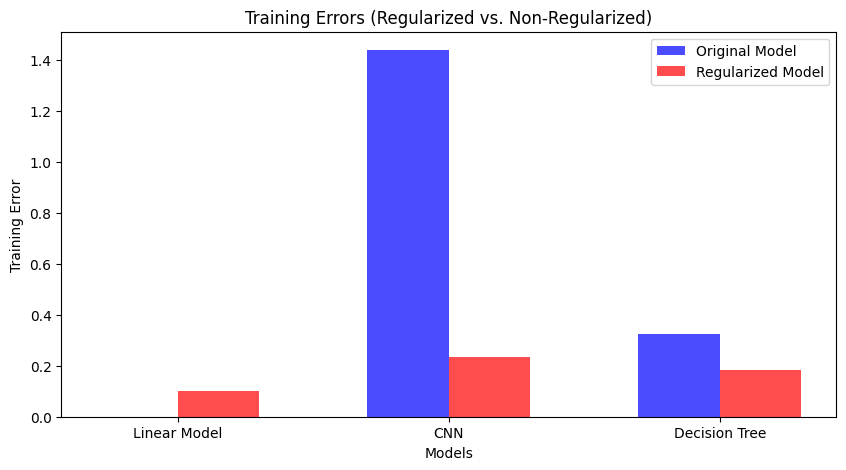

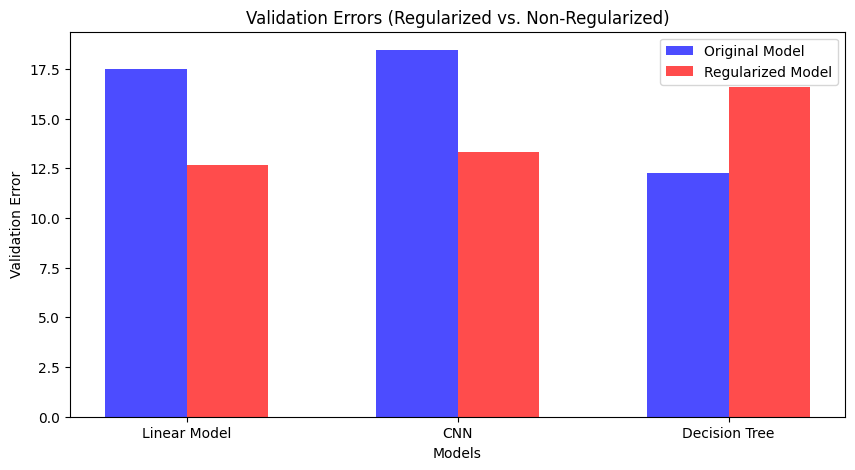

In [78]:

# Define model names
models = ["Linear Model", "CNN", "Decision Tree"]

# Training errors
train_errors = [model_train_error, cnn_train_error, tree_train_error]
custom_train_errors = [custom_reg_train_error, cnn_custom_train_error, custom_tree_train_error]

# Validation errors
val_errors = [model_val_error, cnn_val_error, tree_val_error]
custom_val_errors = [custom_reg_val_error, cnn_custom_val_error, custom_tree_val_error]

# Create a DataFrame for better visualization
error_data = pd.DataFrame({
    "Model": models,
    "Training Error (Original)": train_errors,
    "Training Error (Regularized)": custom_train_errors,
    "Validation Error (Original)": val_errors,
    "Validation Error (Regularized)": custom_val_errors
})

# Print the table
print(error_data.to_string(index=False))

# Define x-axis positions for grouped bar charts
x = np.arange(len(models))  # Model positions
width = 0.3  # Bar width for better visualization

# Plot Training Errors
plt.figure(figsize=(10, 5))
plt.bar(x - width/2, train_errors, width, label='Original Model', color='blue', alpha=0.7)
plt.bar(x + width/2, custom_train_errors, width, label='Regularized Model', color='red', alpha=0.7)
plt.xlabel("Models")
plt.ylabel("Training Error")
plt.title("Training Errors (Regularized vs. Non-Regularized)")
plt.xticks(ticks=x, labels=models)
plt.legend()
plt.show()

# Plot Validation Errors
plt.figure(figsize=(10, 5))
plt.bar(x - width/2, val_errors, width, label='Original Model', color='blue', alpha=0.7)
plt.bar(x + width/2, custom_val_errors, width, label='Regularized Model', color='red', alpha=0.7)
plt.xlabel("Models")
plt.ylabel("Validation Error")
plt.title("Validation Errors (Regularized vs. Non-Regularized)")
plt.xticks(ticks=x, labels=models)
plt.legend()
plt.show()